In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import ttest_ind, norm, chi2_contingency, f_oneway, shapiro, kstest
from sklearn.linear_model import LinearRegression

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('data-hotel-clean.csv', index_col=0)

df.sample(5)

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,courtesy,arrival_date
63882,City Hotel,True,346,8,0,2,2,0,0,BB,Undefined,Online TA,TA/TO,False,0,0,A,A,0,9.0,0,Transient,81.90,0,0,Canceled,2016-08-01,False,2016-02-24
18507,Resort Hotel,False,36,47,0,2,1,0,0,FB,Spain,Groups,TA/TO,False,0,0,A,A,0,38.0,0,Undefined,0.00,0,0,Check-Out,2015-11-22,True,2015-11-20
1636,Resort Hotel,False,128,28,2,5,51,0,0,BB,Ireland,Undefined,TA/TO,False,0,0,E,E,0,95.0,0,Undefined,97.50,0,0,Check-Out,2015-09-13,False,2015-09-06
111314,City Hotel,False,144,18,2,1,2,0,0,BB,Undefined,Undefined,TA/TO,False,0,0,A,A,2,52.0,0,Transient-Party,90.00,0,0,Check-Out,2017-09-05,False,2017-05-06
31364,Resort Hotel,False,124,52,1,2,2,0,0,BB,Spain,Online TA,TA/TO,False,0,0,A,A,0,240.0,0,Transient-Party,51.13,0,3,Check-Out,2016-12-26,False,2016-12-23


In [3]:
df['arrival_date'] =df['arrival_date'].str.replace('2016-2-31', '2016-2-28')
df['arrival_date'] =df['arrival_date'].str.replace('2015-2-29', '2015-2-28')

In [4]:


filas_conteniendo_31 = df[df["reservation_status_date"].str.contains('31', na=False)]
valores_unicos = filas_conteniendo_31["reservation_status_date"].unique()


df['reservation_status_date'] = df['reservation_status_date'].str.replace(r'31$', '28', regex=True)
df['reservation_status_date'] = df['reservation_status_date'].str.replace(r'30$', '28', regex=True)

In [5]:
formato_fecha = "%Y-%m-%d"

try:
    df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], format=formato_fecha)
except ValueError as e:
    # Si ocurre un error al convertir la fecha, imprime el mensaje de error
    print("Error al convertir la fecha:", e)

In [6]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

### Objeto análisis

- Por qué han aumentado las cancelaciones?

1. Analizar cuanto respresentas las cancelaciones del total

Indica si la reserva fue cancelada (True) o no (False)

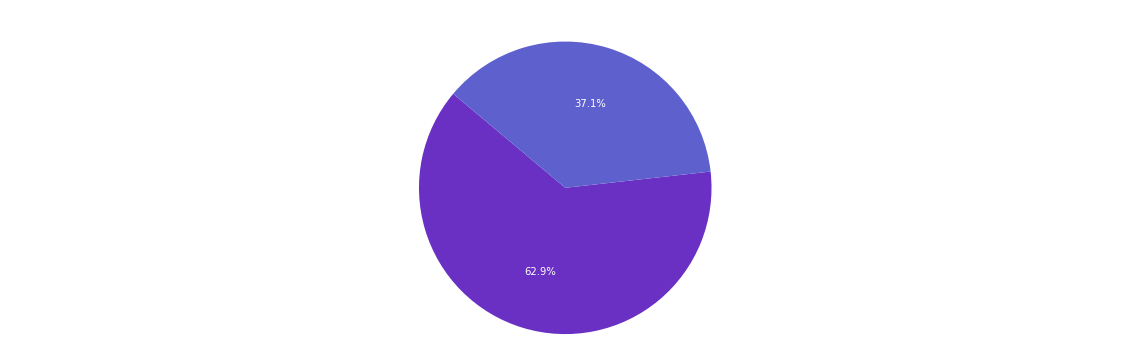

In [38]:
cancelaciones = df["is_canceled"].value_counts()

etiquetas = ["No Cancelado", "Cancelado"]

plt.figure(figsize=(20, 6))
plt.pie(cancelaciones.values, 
        labels=etiquetas, 
        autopct='%1.1f%%', 
        colors=["#6930c3", "#5e60ce"],
        startangle=140, textprops={'color':"white"})
plt.axis('equal')
plt.title('Distribución de las cancelaciones', fontsize = 16, fontweight = "bold", color="white" );

Se cancelan un 37,1% de las reservas

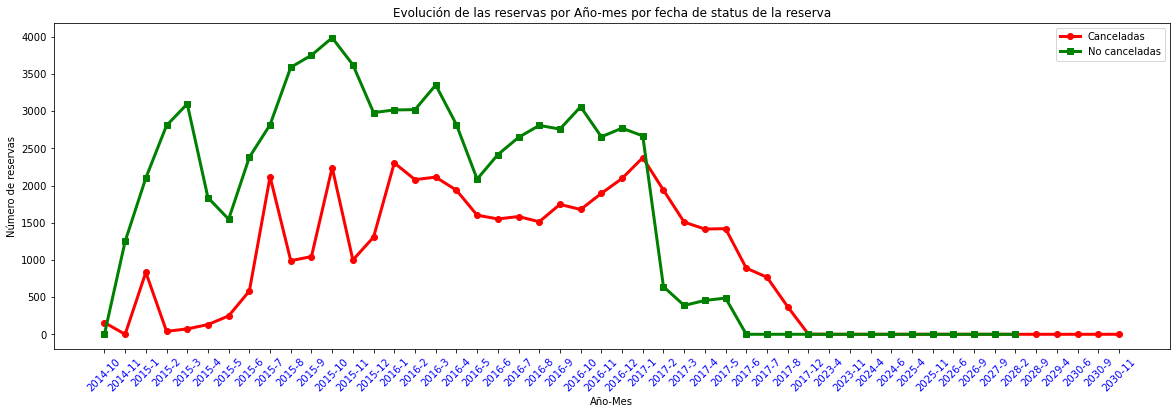

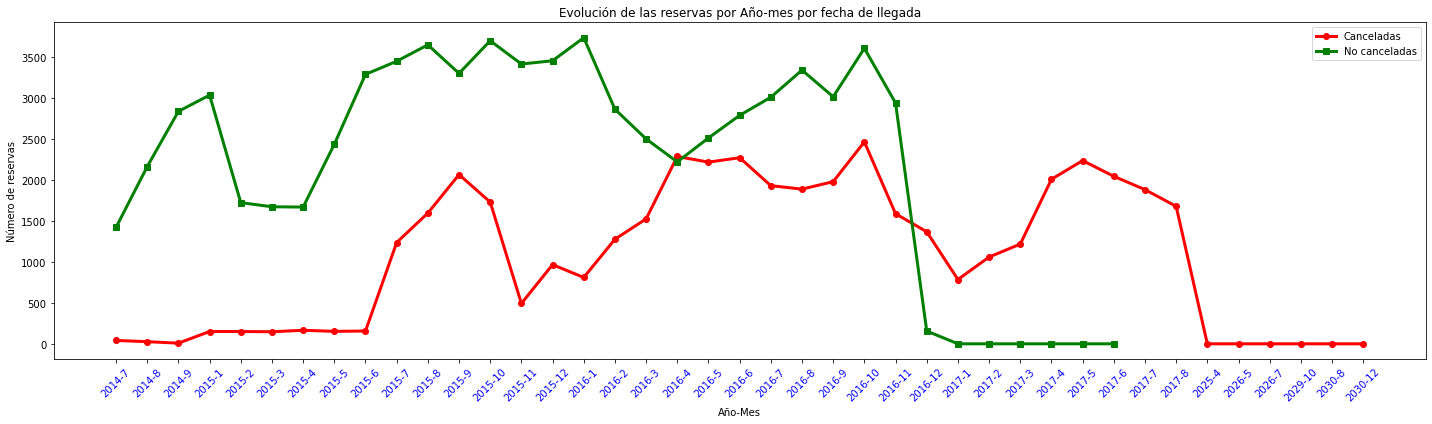

In [8]:
# Primer conjunto de datos basado en la fecha de status de reserva
cancelada_status = df[df["is_canceled"] == True] .groupby([df["reservation_status_date"].dt.year, df["reservation_status_date"].dt.month])["is_canceled"].count()
no_cancelada_status = df[df["is_canceled"] == False].groupby([df["reservation_status_date"].dt.year, df["reservation_status_date"].dt.month])["is_canceled"].count()

etiquetas_x_status = [f'{año}-{mes}' for año, mes in cancelada_status.index]
posiciones_x_status = list(range(len(etiquetas_x_status)))

plt.figure(figsize=(20, 6))

# Trazar la línea para is_canceled == True (status de reserva)
cancelada_status.plot(kind='line', marker='o', linestyle='-', color='red', linewidth=3, label='Canceladas')
# Trazar la línea para is_canceled == False (status de reserva)
no_cancelada_status.plot(kind='line', marker='s', linestyle='-', color='green', linewidth=3, label='No canceladas')

plt.title('Evolución de las reservas por Año-mes por fecha de status de la reserva')
plt.xlabel('Año-Mes')
plt.ylabel('Número de reservas')

plt.xticks(posiciones_x_status, etiquetas_x_status, color="blue", fontsize=10, rotation=45)

plt.legend()

# Segundo conjunto de datos basado en la fecha de llegada
cancelada_llegada = df[df["is_canceled"] == True].groupby([df["arrival_date"].dt.year, df["arrival_date"].dt.month])["is_canceled"].count()
no_cancelada_llegada = df[df["is_canceled"] == False].groupby([df["arrival_date"].dt.year, df["arrival_date"].dt.month])["is_canceled"].count()

etiquetas_x_llegada = [f'{año}-{mes}' for año, mes in cancelada_llegada.index]
posiciones_x_llegada = list(range(len(etiquetas_x_llegada)))

plt.figure(figsize=(20, 6))

# Trazar la línea para is_canceled == True (fecha de llegada)
cancelada_llegada.plot(kind='line', marker='o', linestyle='-', color='red', linewidth=3, label='Canceladas')
# Trazar la línea para is_canceled == False (fecha de llegada)
no_cancelada_llegada.plot(kind='line', marker='s', linestyle='-', color='green', linewidth=3, label='No canceladas')

plt.title('Evolución de las reservas por Año-mes por fecha de llegada')
plt.xlabel('Año-Mes')
plt.ylabel('Número de reservas')

plt.xticks(posiciones_x_llegada, etiquetas_x_llegada, color="blue", fontsize=10, rotation=45)

plt.legend()

plt.tight_layout()
plt.show()


En Abril de 2016, por fecha de llegada, se igualan las reservas canceladas a las no canceladas.
En Diciembre de 2016 vuelve a ocurrir estoy después de esa fecha, son más las cancelaciones que las reservas en el hotel.

In [9]:
df.sample(5)

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,courtesy,arrival_date
32015,Resort Hotel,False,4,2,0,1,50,0,0,HB,Portugal,Undefined,TA/TO,False,0,0,A,A,0,168.0,0,Undefined,68.00,0,0,Check-Out,2017-01-15,False,2017-01-14
79591,City Hotel,False,7,44,0,1,1,0,0,BB,Undefined,Direct,Undefined,False,0,0,A,A,0,Undefined,0,Transient-Party,65.00,0,0,Check-Out,2015-10-28,False,2015-10-29
118344,City Hotel,False,69,28,2,4,2,0,0,SC,Brazil,Undefined,TA/TO,False,0,0,A,A,0,9.0,0,Transient,140.00,0,2,Check-Out,2016-08-13,False,2016-08-13
71919,City Hotel,True,476,28,2,1,2,0,0,BB,Portugal,Offline TA/TO,TA/TO,False,0,0,Undefined,A,0,229.0,0,Transient-Party,112.67,0,0,Canceled,2017-07-03,False,2017-07-15
94677,City Hotel,False,137,31,3,7,2,0,0,HB,Undefined,Online TA,TA/TO,False,0,0,D,D,0,9.0,0,Transient,147.90,0,1,Check-Out,2016-08-08,False,2016-07-29


In [10]:
df["hotel"].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

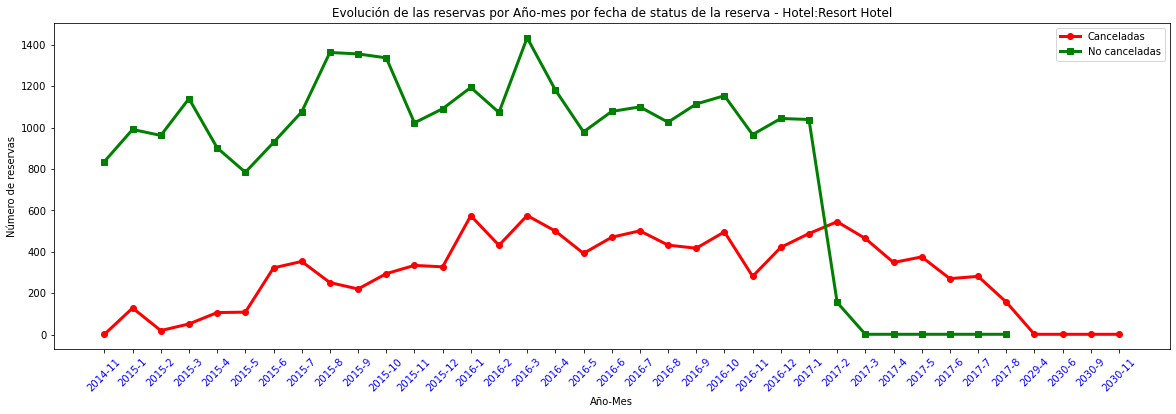

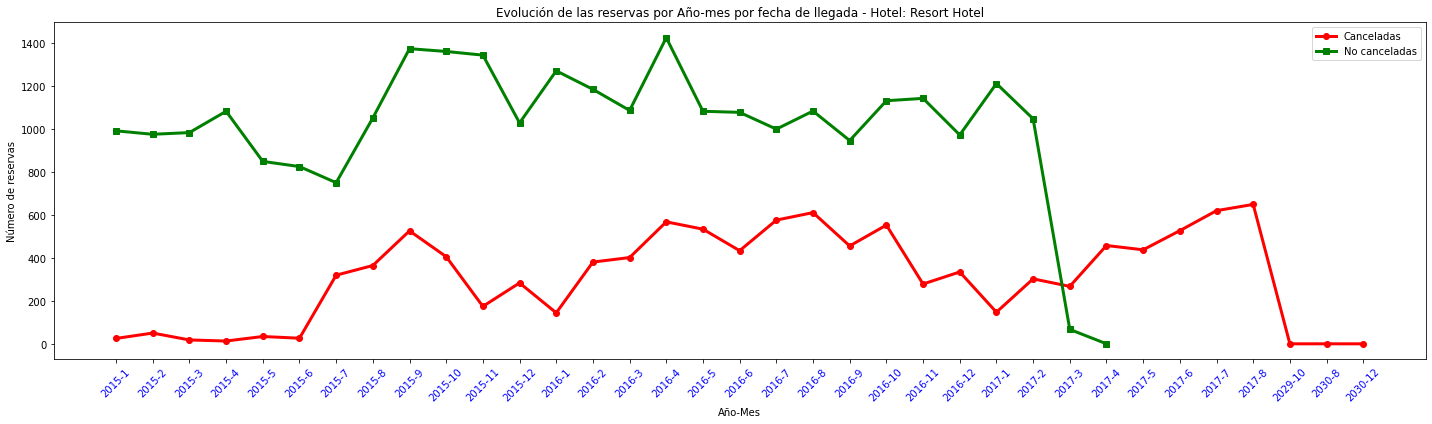

In [11]:
# Primer conjunto de datos basado en la fecha de status de reserva y el hotel
cancelada_status = df[(df["is_canceled"] == True) & (df["hotel"] == "Resort Hotel")].groupby([df["reservation_status_date"].dt.year, df["reservation_status_date"].dt.month])["is_canceled"].count()
no_cancelada_status = df[(df["is_canceled"] == False) & (df["hotel"] == "Resort Hotel")].groupby([df["reservation_status_date"].dt.year, df["reservation_status_date"].dt.month])["is_canceled"].count()

etiquetas_x_status = [f'{año}-{mes}' for año, mes in cancelada_status.index]
posiciones_x_status = list(range(len(etiquetas_x_status)))

plt.figure(figsize=(20, 6))

# Trazar la línea para is_canceled == True (status de reserva)
cancelada_status.plot(kind='line', marker='o', linestyle='-', color='red', linewidth=3, label='Canceladas')
# Trazar la línea para is_canceled == False (status de reserva)
no_cancelada_status.plot(kind='line', marker='s', linestyle='-', color='green', linewidth=3, label='No canceladas')

plt.title('Evolución de las reservas por Año-mes por fecha de status de la reserva - Hotel:Resort Hotel')
plt.xlabel('Año-Mes')
plt.ylabel('Número de reservas')

plt.xticks(posiciones_x_status, etiquetas_x_status, color="blue", fontsize=10, rotation=45)

plt.legend()

# Segundo conjunto de datos basado en la fecha de llegada y el hotel
cancelada_llegada = df[(df["is_canceled"] == True) & (df["hotel"] == "Resort Hotel")].groupby([df["arrival_date"].dt.year, df["arrival_date"].dt.month])["is_canceled"].count()
no_cancelada_llegada = df[(df["is_canceled"] == False) & (df["hotel"] == "Resort Hotel")].groupby([df["arrival_date"].dt.year, df["arrival_date"].dt.month])["is_canceled"].count()

etiquetas_x_llegada = [f'{año}-{mes}' for año, mes in cancelada_llegada.index]
posiciones_x_llegada = list(range(len(etiquetas_x_llegada)))

plt.figure(figsize=(20, 6))

# Trazar la línea para is_canceled == True (fecha de llegada)
cancelada_llegada.plot(kind='line', marker='o', linestyle='-', color='red', linewidth=3, label='Canceladas')
# Trazar la línea para is_canceled == False (fecha de llegada)
no_cancelada_llegada.plot(kind='line', marker='s', linestyle='-', color='green', linewidth=3, label='No canceladas')

plt.title('Evolución de las reservas por Año-mes por fecha de llegada - Hotel: Resort Hotel')
plt.xlabel('Año-Mes')
plt.ylabel('Número de reservas')

plt.xticks(posiciones_x_llegada, etiquetas_x_llegada, color="blue", fontsize=10, rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

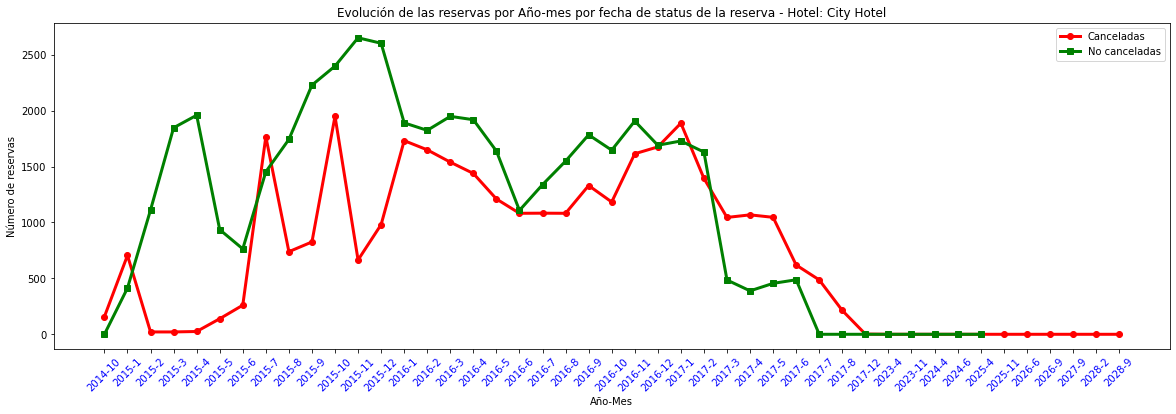

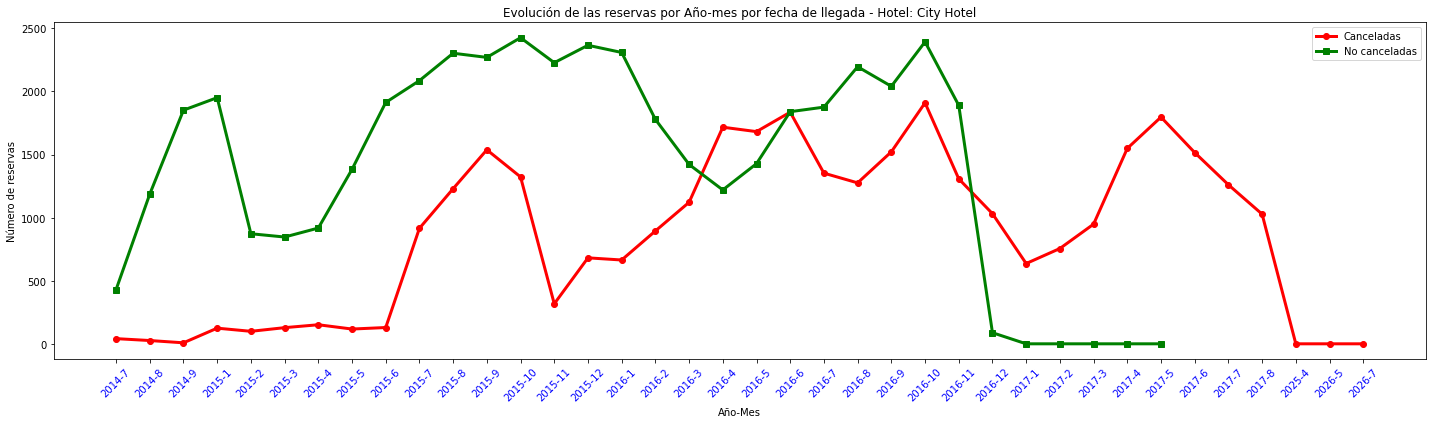

In [12]:
# Primer conjunto de datos basado en la fecha de status de reserva y el hotel
cancelada_status = df[(df["is_canceled"] == True) & (df["hotel"] == "City Hotel")].groupby([df["reservation_status_date"].dt.year, df["reservation_status_date"].dt.month])["is_canceled"].count()
no_cancelada_status = df[(df["is_canceled"] == False) & (df["hotel"] == "City Hotel")].groupby([df["reservation_status_date"].dt.year, df["reservation_status_date"].dt.month])["is_canceled"].count()

etiquetas_x_status = [f'{año}-{mes}' for año, mes in cancelada_status.index]
posiciones_x_status = list(range(len(etiquetas_x_status)))

plt.figure(figsize=(20, 6))

# Trazar la línea para is_canceled == True (status de reserva)
cancelada_status.plot(kind='line', marker='o', linestyle='-', color='red', linewidth=3, label='Canceladas')
# Trazar la línea para is_canceled == False (status de reserva)
no_cancelada_status.plot(kind='line', marker='s', linestyle='-', color='green', linewidth=3, label='No canceladas')

plt.title('Evolución de las reservas por Año-mes por fecha de status de la reserva - Hotel: City Hotel')
plt.xlabel('Año-Mes')
plt.ylabel('Número de reservas')

plt.xticks(posiciones_x_status, etiquetas_x_status, color="blue", fontsize=10, rotation=45)

plt.legend()

# Segundo conjunto de datos basado en la fecha de llegada y el hotel
cancelada_llegada = df[(df["is_canceled"] == True) & (df["hotel"] == "City Hotel")].groupby([df["arrival_date"].dt.year, df["arrival_date"].dt.month])["is_canceled"].count()
no_cancelada_llegada = df[(df["is_canceled"] == False) & (df["hotel"] == "City Hotel")].groupby([df["arrival_date"].dt.year, df["arrival_date"].dt.month])["is_canceled"].count()

etiquetas_x_llegada = [f'{año}-{mes}' for año, mes in cancelada_llegada.index]
posiciones_x_llegada = list(range(len(etiquetas_x_llegada)))

plt.figure(figsize=(20, 6))

# Trazar la línea para is_canceled == True (fecha de llegada)
cancelada_llegada.plot(kind='line', marker='o', linestyle='-', color='red', linewidth=3, label='Canceladas')
# Trazar la línea para is_canceled == False (fecha de llegada)
no_cancelada_llegada.plot(kind='line', marker='s', linestyle='-', color='green', linewidth=3, label='No canceladas')

plt.title('Evolución de las reservas por Año-mes por fecha de llegada - Hotel: City Hotel')
plt.xlabel('Año-Mes')
plt.ylabel('Número de reservas')

plt.xticks(posiciones_x_llegada, etiquetas_x_llegada, color="blue", fontsize=10, rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

In [5]:
cancelada_llegada = df[(df["is_canceled"] == True) & (df["hotel"] == "City Hotel") & (df["arrival_date"].dt.year == 2016) & (df["arrival_date"].dt.month == 4)].groupby([df["arrival_date"].dt.year, df["arrival_date"].dt.month])["is_canceled"].count()

AttributeError: Can only use .dt accessor with datetimelike values

- El hote con más volatilidad en la cancelación es el City Hotel. Aunque el hotel Resort ha experimentado disminución en sus reservas en los últimos tiempos

In [13]:
df.sample(5)

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,courtesy,arrival_date
75251,City Hotel,True,297,33,1,1,2,0,0,BB,Portugal,Undefined,TA/TO,False,1,0,A,A,0,1.0,0,Transient-Party,62.00,0,0,Canceled,2015-07-02,False,2015-08-10
98232,City Hotel,False,1,39,1,3,2,0,0,BB,Portugal,Offline TA/TO,TA/TO,False,0,0,Undefined,A,0,315.0,0,Transient-Party,176.00,0,0,Check-Out,2016-09-26,False,2016-09-22
41367,City Hotel,False,40,33,2,2,2,0,0,BB,Spain,Groups,TA/TO,False,0,0,A,A,0,1.0,0,Transient-Party,62.00,0,0,Check-Out,2024-09-28,False,2024-08-15
64911,City Hotel,True,8,12,1,3,53,0,0,SC,Undefined,Undefined,TA/TO,False,0,0,A,A,0,9.0,0,Transient,83.30,0,0,Canceled,2017-03-12,False,2017-03-20
89240,City Hotel,False,6,28,1,2,2,0,0,BB,Argentina,Online TA,TA/TO,False,0,0,A,A,0,9.0,0,Transient,121.67,0,1,Check-Out,2016-05-19,False,2016-05-16


In [14]:
df["country"].unique()

array(['Portugal', 'Undefined', 'United Kingdom', 'United States',
       'Spain', 'Ireland', 'France', 'Romania', 'Norway', 'Oman',
       'Argentina', 'Germany', 'Switzerland', 'Greece', 'Netherlands',
       'Denmark', 'Russia', 'Poland', 'Australia', 'Estonia',
       'Czech Republic', 'Brazil', 'Belgium', 'China', 'Sweden',
       'Finland', 'Mozambique', 'Slovenia', 'Morocco', 'Italy', 'Ukraine',
       'San Marino', 'Latvia', 'Puerto Rico', 'Chile', 'Lithuania',
       'Luxembourg', 'Austria', 'Turkey', 'Mexico', 'South Africa',
       'Angola', 'Israel', 'India', 'Cayman Islands', 'Zambia',
       'Cape Verde', 'Zimbabwe', 'Algeria', 'South Korea', 'Hungary',
       'United Arab Emirates', 'Tunisia', 'Jamaica', 'Albania', 'Croatia',
       'Hong Kong', 'Andorra', 'Gibraltar', 'Uruguay', 'Belarus',
       'Jersey', 'Cyprus', 'Maldives', 'Fiji', 'Kazakhstan', 'Pakistan',
       'Indonesia', 'Lebanon', 'Philippines', 'Colombia', 'Senegal',
       'Georgia', 'Azerbaijan', 'Bahrain'

In [15]:
paises_a_continentes = {
    'Portugal': 'Europa',
    'Undefined': 'Desconocido',
    'United Kingdom': 'Europa',
    'United States': 'América del Norte',
    'Spain': 'Europa',
    'Ireland': 'Europa',
    'France': 'Europa',
    'Romania': 'Europa',
    'Norway': 'Europa',
    'Oman': 'Asia',
    'Argentina': 'América del Sur',
    'Germany': 'Europa',
    'Switzerland': 'Europa',
    'Greece': 'Europa',
    'Netherlands': 'Europa',
    'Denmark': 'Europa',
    'Russia': 'Europa',
    'Poland': 'Europa',
    'Australia': 'Oceanía',
    'Estonia': 'Europa',
    'Czech Republic': 'Europa',
    'Brazil': 'América del Sur',
    'Belgium': 'Europa',
    'China': 'Asia',
    'Sweden': 'Europa',
    'Finland': 'Europa',
    'Mozambique': 'África',
    'Slovenia': 'Europa',
    'Morocco': 'África',
    'Italy': 'Europa',
    'Ukraine': 'Europa',
    'San Marino': 'Europa',
    'Latvia': 'Europa',
    'Puerto Rico': 'América del Norte',
    'Chile': 'América del Sur',
    'Lithuania': 'Europa',
    'Luxembourg': 'Europa',
    'Austria': 'Europa',
    'Turkey': 'Asia',
    'Mexico': 'América del Norte',
    'South Africa': 'África',
    'Angola': 'África',
    'Israel': 'Asia',
    'India': 'Asia',
    'Cayman Islands': 'América del Norte',
    'Zambia': 'África',
    'Cape Verde': 'África',
    'Zimbabwe': 'África',
    'Algeria': 'África',
    'South Korea': 'Asia',
    'Hungary': 'Europa',
    'United Arab Emirates': 'Asia',
    'Tunisia': 'África',
    'Jamaica': 'América del Norte',
    'Albania': 'Europa',
    'Croatia': 'Europa',
    'Hong Kong': 'Asia',
    'Andorra': 'Europa',
    'Gibraltar': 'Europa',
    'Uruguay': 'América del Sur',
    'Belarus': 'Europa',
    'Jersey': 'Europa',
    'Cyprus': 'Europa',
    'Maldives': 'Asia',
    'Fiji': 'Oceanía',
    'Kazakhstan': 'Asia',
    'Pakistan': 'Asia',
    'Indonesia': 'Asia',
    'Lebanon': 'Asia',
    'Philippines': 'Asia',
    'Colombia': 'América del Sur',
    'Senegal': 'África',
    'Georgia': 'Asia',
    'Azerbaijan': 'Asia',
    'Bahrain': 'Asia',
    'New Zealand': 'Oceanía',
    'Thailand': 'Asia',
    'Dominican Republic': 'América del Norte',
    'Malaysia': 'Asia',
    'Venezuela': 'América del Sur',
    'Armenia': 'Asia',
    'Sri Lanka': 'Asia',
    'Cuba': 'América del Norte',
    'Cameroon': 'África',
    'Iran': 'Asia',
    'Nigeria': 'África',
    'Comoros': 'África',
    'Bulgaria': 'Europa',
    "Côte d'Ivoire": 'África',
    'Serbia': 'Europa',
    'Jordan': 'Asia',
    'Syria': 'Asia',
    'Burundi': 'África',
    'Singapore': 'Asia',
    'Kuwait': 'Asia',
    'Palau': 'Oceanía',
    'Qatar': 'Asia',
    'Slovakia': 'Europa',
    'Suriname': 'América del Sur',
    'Malta': 'Europa',
    'Malawi': 'África',
    'Madagascar': 'África',
    'Iceland': 'Europa',
    'Japan': 'Asia',
    'Central African Republic': 'África',
    'Togo': 'África',
    'Taiwan': 'Asia',
    'Djibouti': 'África',
    'Vietnam': 'Asia',
    'Peru': 'América del Sur',
    'Egypt': 'África',
    'Saudi Arabia': 'Asia',
    'Saint Kitts and Nevis': 'América del Norte',
    'Ethiopia': 'África',
    'Ecuador': 'América del Sur',
    'Iraq': 'Asia',
    'Cambodia': 'Asia',
    'Monaco': 'Europa',
    'Bangladesh': 'Asia',
    'Tajikistan': 'Asia',
    'Nicaragua': 'América del Norte',
    'Guernsey': 'Europa',
    'Benin': 'África',
    'British Virgin Islands': 'América del Norte',
    'Costa Rica': 'América del Norte',
    'Tanzania': 'África',
    'Gabon': 'África',
    'North Macedonia': 'Europa',
    'Bosnia and Herzegovina': 'Europa',
    'East Timor': 'Oceanía',
    'Guadeloupe': 'América del Norte',
    'Liechtenstein': 'Europa',
    'Guinea-Bissau': 'África',
    'Macau': 'Asia',
    'Isle of Man': 'Europa',
    'United States Minor Outlying Islands': 'Oceanía',
    'Mayotte': 'África',
    'Ghana': 'África',
    'Faroe Islands': 'Europa',
    'Myanmar': 'Asia',
    'Panama': 'América del Norte',
    'Mauritius': 'África',
    'Libya': 'África',
    'Namibia': 'África',
    'Bolivia': 'América del Sur',
    'Paraguay': 'América del Sur',
    'Barbados': 'América del Norte',
    'Aruba': 'América del Norte',
    'Anguilla': 'América del Norte',
    'Dominica': 'América del Norte',
    'Uganda': 'África',
    'Montenegro': 'Europa',
    'Guatemala': 'América del Norte',
    'American Samoa': 'Oceanía',
    'Kenya': 'África',
    'New Caledonia': 'Oceanía',
    'São Tomé and Príncipe': 'África',
    'Kiribati': 'Oceanía',
    'Sudan': 'África',
    'French Southern Territories': 'Antártida',
    'Sierra Leone': 'África',
    'El Salvador': 'América del Norte',
    'Laos': 'Asia'
}

In [16]:
df['continente'] = df['country'].map(paises_a_continentes)

In [17]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,courtesy,arrival_date,continente
0,Resort Hotel,False,342,27,0,0,2,0,0,BB,Portugal,Undefined,Direct,False,0,0,C,C,3,Undefined,0,Transient,0.0,0,0,Check-Out,2015-07-01,True,2015-07-01,Europa
1,Resort Hotel,False,737,27,0,0,2,0,0,BB,Undefined,Undefined,Direct,False,0,0,Undefined,C,4,Undefined,0,Transient,0.0,0,0,Check-Out,2015-07-01,True,2015-07-01,Desconocido
2,Resort Hotel,False,7,27,0,1,1,0,0,BB,United Kingdom,Undefined,Direct,False,0,0,A,C,0,Undefined,0,Transient,75.0,0,0,Check-Out,2015-07-02,False,2015-07-01,Europa
3,Resort Hotel,False,13,27,0,1,1,0,0,BB,United Kingdom,Corporate,Corporate,False,0,0,A,A,0,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,False,2015-07-01,Europa
4,Resort Hotel,False,14,28,0,2,2,0,0,BB,Undefined,Online TA,TA/TO,False,0,0,A,A,0,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,False,2015-07-01,Desconocido


In [18]:
df2 = df[df["is_canceled"] == False]


In [19]:
country = df["country"].unique()

for pais in country:
    cancelada = df[(df["hotel"] == "City Hotel") & (df["country"] == pais) & (df["is_canceled"] == True)]["is_canceled"].count()
    no_cancelada = df[(df["hotel"] == "City Hotel") & (df["country"] == pais) & (df["is_canceled"] != True)]["is_canceled"].count()

    print(f'Para el país {pais} en el hotel "City Hotel" el total de cancelaciones fue {cancelada} y el total de reservas {no_cancelada}')
    print("------------------------------------------------------------------------------------------------------------------------")

Para el país Portugal en el hotel "City Hotel" el total de cancelaciones fue 10914 y el total de reservas 5906
------------------------------------------------------------------------------------------------------------------------
Para el país Undefined en el hotel "City Hotel" el total de cancelaciones fue 14625 y el total de reservas 20328
------------------------------------------------------------------------------------------------------------------------
Para el país United Kingdom en el hotel "City Hotel" el total de cancelaciones fue 881 y el total de reservas 2053
------------------------------------------------------------------------------------------------------------------------
Para el país United States en el hotel "City Hotel" el total de cancelaciones fue 245 y el total de reservas 650
------------------------------------------------------------------------------------------------------------------------
Para el país Spain en el hotel "City Hotel" el total de cancelac

In [20]:
top_10_no_canceladas_por_pais = df[df["is_canceled"] != True].groupby("country")["is_canceled"].count().nlargest(10)
print("Top 10 de reservas no canceladas por país:")
print(top_10_no_canceladas_por_pais)

Top 10 de reservas no canceladas por país:
country
Undefined         33179
Portugal          11458
United Kingdom     5184
France             4660
Spain              3499
Germany            3318
Ireland            1340
Italy              1336
Belgium            1027
Netherlands         939
Name: is_canceled, dtype: int64


In [21]:
top_10_no_canceladas_por_pais = df[df["is_canceled"] == True].groupby("country")["is_canceled"].count().nlargest(10)
print("Top 10 de reservas canceladas por país:")
print(top_10_no_canceladas_por_pais)

Top 10 de reservas canceladas por país:
country
Undefined         19546
Portugal          14935
United Kingdom     1370
Spain              1192
France             1069
Italy               727
Germany             644
Ireland             453
Brazil              429
China               389
Name: is_canceled, dtype: int64


In [22]:
top_10_no_canceladas_por_pais = df[df["is_canceled"] != True].groupby("country")["is_canceled"].count().nlargest(10)
paises_top_10 = top_10_no_canceladas_por_pais.index.tolist()

df_top_10_paises = df[df['country'].isin(paises_top_10)]


media = df_top_10_paises.groupby([
    df_top_10_paises['arrival_date'].dt.year.rename("year"),
    df_top_10_paises['arrival_date'].dt.month.rename("month"),
    df_top_10_paises['country'],
    df_top_10_paises['hotel'],
    df_top_10_paises['continente'],
    df_top_10_paises['is_canceled']  # Suponiendo que 'is_canceled' es una columna en tu DataFrame
    ])['adr'].mean()

In [23]:
media

year  month  country    hotel         continente   is_canceled
2014  7      Portugal   City Hotel    Europa       True            62.8
             Undefined  City Hotel    Desconocido  True            62.8
      8      Portugal   City Hotel    Europa       True            62.8
             Undefined  City Hotel    Desconocido  True            62.8
      9      Portugal   City Hotel    Europa       True            62.8
                                                                  ...  
2027  4      Undefined  City Hotel    Desconocido  False          100.8
2029  10     Portugal   Resort Hotel  Europa       True            38.0
2030  4      Undefined  City Hotel    Desconocido  False          108.0
      8      Undefined  Resort Hotel  Desconocido  True           222.0
      12     Portugal   Resort Hotel  Europa       True            72.0
Name: adr, Length: 1004, dtype: float64

In [24]:
df_media = media.reset_index()

In [25]:
df_media

,year,month,country,hotel,continente,is_canceled,adr
0,2014,7,Portugal,City Hotel,Europa,True,62.8
1,2014,7,Undefined,City Hotel,Desconocido,True,62.8
2,2014,8,Portugal,City Hotel,Europa,True,62.8
3,2014,8,Undefined,City Hotel,Desconocido,True,62.8
4,2014,9,Portugal,City Hotel,Europa,True,62.8
...,...,...,...,...,...,...,...
999,2027,4,Undefined,City Hotel,Desconocido,False,100.8
1000,2029,10,Portugal,Resort Hotel,Europa,True,38.0
1001,2030,4,Undefined,City Hotel,Desconocido,False,108.0
1002,2030,8,Undefined,Resort Hotel,Desconocido,True,222.0


In [26]:
df_canceled_false = df_media[(df_media['hotel'] == 'City Hotel') & (df_media['is_canceled'] == False)]


In [27]:
df_canceled_false

,year,month,country,hotel,continente,is_canceled,adr
38,2015,7,France,City Hotel,Europa,False,76.500000
40,2015,7,Germany,City Hotel,Europa,False,61.980000
43,2015,7,Italy,City Hotel,Europa,False,75.437500
47,2015,7,Portugal,City Hotel,Europa,False,75.394464
51,2015,7,Spain,City Hotel,Europa,False,49.200000
...,...,...,...,...,...,...,...
991,2017,12,United Kingdom,City Hotel,Europa,False,53.470000
994,2024,8,Spain,City Hotel,Europa,False,62.000000
995,2024,10,Undefined,City Hotel,Desconocido,False,80.750000
999,2027,4,Undefined,City Hotel,Desconocido,False,100.800000


In [28]:
df_canceled_false.sort_values(by= "adr",ascending=False)

,year,month,country,hotel,continente,is_canceled,adr
979,2017,12,Belgium,City Hotel,Europa,False,271.290000
987,2017,12,Spain,City Hotel,Europa,False,174.540000
967,2017,8,Spain,City Hotel,Europa,False,153.238438
943,2017,8,France,City Hotel,Europa,False,150.051813
840,2017,5,Netherlands,City Hotel,Europa,False,147.047895
...,...,...,...,...,...,...,...
57,2015,7,United Kingdom,City Hotel,Europa,False,61.980000
40,2015,7,Germany,City Hotel,Europa,False,61.980000
991,2017,12,United Kingdom,City Hotel,Europa,False,53.470000
51,2015,7,Spain,City Hotel,Europa,False,49.200000


In [29]:
# Dividir la lista de países en dos partes
mitad = len(paises) // 2
paises_primera_fila = paises[:mitad]
paises_segunda_fila = paises[mitad:]

# Crear subgráficos para la primera fila de países
fig, axes = plt.subplots(ncols=len(paises_primera_fila), figsize=(6*len(paises_primera_fila), 8), sharey=True)

# Iterar sobre cada país en la primera fila y crear un gráfico de líneas
for i, pais in enumerate(paises_primera_fila):
    # Filtrar los datos para el país actual
    datos_pais = costo_medio_por_pais.loc[pais]
    # Crear un gráfico de líneas para el país actual
    datos_pais.plot(ax=axes[i], marker='o', linestyle='-')
    axes[i].set_title(f'Costo Medio del Hotel en {pais}')
    axes[i].set_xlabel('Fecha')
    axes[i].set_ylabel('Costo Medio del Hotel')

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Mostrar los gráficos de la primera fila
plt.show()

# Crear subgráficos para la segunda fila de países
fig, axes = plt.subplots(ncols=len(paises_segunda_fila), figsize=(6*len(paises_segunda_fila), 8), sharey=True)

# Iterar sobre cada país en la segunda fila y crear un gráfico de líneas
for i, pais in enumerate(paises_segunda_fila):
    # Filtrar los datos para el país actual
    datos_pais = costo_medio_por_pais.loc[pais]
    # Crear un gráfico de líneas para el país actual
    datos_pais.plot(ax=axes[i], marker='o', linestyle='-')
    axes[i].set_title(f'Costo Medio del Hotel en {pais}')
    axes[i].set_xlabel('Fecha')
    axes[i].set_ylabel('Costo Medio del Hotel')

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Mostrar los gráficos de la segunda fila
plt.show()

NameError: name 'paises' is not defined